In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
train_folder = '/content/drive/MyDrive/lung/train'
test_folder = '/content/drive/MyDrive/lung/test'
validate_folder = '/content/drive/MyDrive/lung/valid'

# Define paths to the specific classes within the dataset
normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'

In [ ]:
import os

train_folder = '/content/drive/MyDrive/lung/train'
test_folder = '/content/drive/MyDrive/lung/test'
validate_folder = '/content/drive/MyDrive/lung/valid'

def print_all_files(folder, folder_name):
    print(f"Files in {folder_name}:")
    if os.path.exists(folder):
        for root, _, files in os.walk(folder):
            for file in files:
                print(os.path.join(root, file))
    else:
        print(f"{folder_name} not found.")
    print("\n")

print_all_files(train_folder, "Train Folder")
print_all_files(test_folder, "Test Folder")
print_all_files(validate_folder, "Validate Folder")


Files in Train Folder:
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000004 (4).png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000006 (4).png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000017 (4).png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000015 (7).png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000004 (5).png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000013 (6).png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000007.png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000027 (2).png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000002 (6).png
/content/drive/MyDrive/lung/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000024 (5).png
/

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

# Set the image size for resizing
IMAGE_SIZE = (350, 350)

# Initialize the image data generators for training and testing
print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


# Define the batch size for training
batch_size = 8


# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


# Create the validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

Libraries Imported
Reading training images from: /content/drive/MyDrive/lung/train
Reading validation images from: /content/drive/MyDrive/lung/valid
Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
#checkpointer = ModelCheckpoint(filepath='best_model.hdf5', verbose=2, save_best_only=True, save_weights_only=True)

In [ ]:
checkpointer = ModelCheckpoint(filepath='best_model.weights.h5', verbose=2, save_best_only=True, save_weights_only=True)

In [ ]:

# Define the number of output classes
OUTPUT_SIZE = 4

# Load a pre-trained model (Xception) without the top layers and freeze its weights
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

# Create a new model with the pre-trained base and additional layers for classification
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Pretrained model used:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 350, 350, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 174, 174, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 174, 174, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 174, 174, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 172, 172, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 172, 172, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 172, 172, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 172, 172, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 172, 172, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 172, 172, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 86, 86, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 86, 86, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Final model created:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 11, 11, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:

# Define the number of output classes
OUTPUT_SIZE = 4

# Load a pre-trained model (Xception) without the top layers and freeze its weights
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

# Create a new model with the pre-trained base and additional layers for classification
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Function to display training curves for loss and accuracy
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Display training curves for loss and accuracy
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [ ]:
model.save('/content/drive/MyDrive/dataset/trained_lung_cancer_model.h5')


NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define a function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array

# Load, preprocess, and predict the class of an image
#Write a local upload

img_path = '/content/sq.png'


img = load_and_preprocess_image(img_path, IMAGE_SIZE)

# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Map the predicted class to the class label
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

# Print the predicted class
print(f"The image belongs to class: {predicted_label}")

# Display the image with the predicted class
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/content/sq.png'

# ⬇ From Here

In [ ]:


from google.colab import drive
from tensorflow.keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the model
model_path = '/content/drive/MyDrive/lung/trained_lung_cancer_model.h5'
model = load_model(model_path)

print("Model Loaded Successfully!")


Mounted at /content/drive


Model Loaded Successfully!


Saving 000003 (3).png to 000003 (3) (2).png


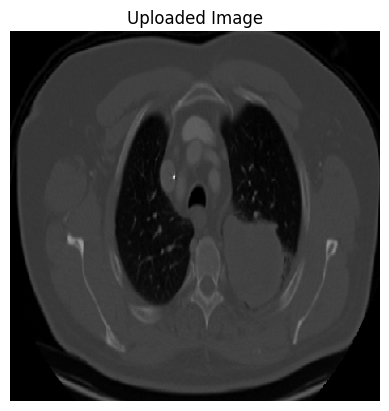

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to preprocess the image
def load_and_preprocess_image(img_path, target_size=(350, 350)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Upload an image for prediction
from google.colab import files
uploaded = files.upload()

# Get the image path
img_path = list(uploaded.keys())[0]

# Load and preprocess the image
img = load_and_preprocess_image(img_path)

# Display the image
plt.imshow(image.load_img(img_path, target_size=(350, 350)))
plt.axis('off')
plt.title("Uploaded Image")
plt.show()


In [ ]:
# Make a prediction
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])

# Get class labels from training data
#class_labels = ['Normal', 'Adenocarcinoma', 'Large Cell Carcinoma', 'Squamous Cell Carcinoma']
class_labels = ['Adenocarcinoma', 'Large Cell Carcinoma', 'Squamous Cell Carcinoma']
# Get the predicted label
predicted_label = class_labels[predicted_class]

# Print the output
print(f"The image belongs to class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
The image belongs to class: Large Cell Carcinoma


In [ ]:
pip install google-generativeai

# Replace ur own gemini api key

In [ ]:
import google.generativeai as genai

genai.configure(api_key="")

# List available models
models = list(genai.list_models())

# Print available models
for model in models:
    print(model.name)


models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/learnlm-1.5-pro-experimental
models/embedding-001
models/text-embedding-004
models/aqa
models/imagen-3.

In [ ]:
# Configure Gemini API
import google.generativeai as genai
genai.configure(api_key="")

# Define the model
gemini_model = genai.GenerativeModel("gemini-1.5-flash")


In [ ]:


# Print the predicted lung cancer type
print(f"Predicted Lung Cancer Type: {predicted_label}")

# Use Gemini to suggest medicines
prompt = f"I have been diagnosed with {predicted_label} lung cancer. Suggest appropriate medicines and treatment options."

response = gemini_model.generate_content(prompt)

# Print medicine recommendations
print("\n🔹 Suggested Treatment & Medicines:\n", response.text)


Predicted Lung Cancer Type: Large Cell Carcinoma

🔹 Suggested Treatment & Medicines:
 I am an AI and cannot provide medical advice.  A diagnosis of Large Cell Carcinoma (LCC) lung cancer requires a highly individualized treatment plan developed by a team of oncologists and other healthcare professionals experienced in treating lung cancer.  The best approach depends on several factors, including:

* **Stage of cancer:**  The extent of the cancer's spread (Stage I, II, III, or IV) is crucial in determining treatment options.
* **Location of the tumor:** The exact location within the lung can influence treatment choices.
* **Patient's overall health:** Age, other medical conditions, and general physical fitness play a significant role.
* **Molecular testing results:**  Testing for specific genetic mutations (like EGFR, ALK, ROS1, etc.) can guide targeted therapy choices.

**Possible Treatment Options (These are NOT recommendations, only potential treatments discussed by oncologists):**

